# Predicting the possibility of Parkinsons with an ML Model

This notebook utilizes various Python-based libraries and tools to build an machine learning model that aims to predict whether a person has Parkinsons or not based on specific biomedical voice measurements obtained from that person.

### Approach:
1. Problem definition
2. Data analysis
    1. Refine features
    2. Split the data as features and labels
    3. Imputation
    4. Delete missing target values
    5. Numerical encoding
    6. Feature scaling if required
3. Identifying evaluation metrics
4. Classifying features
5. Modelling
    1. Split the data into train, validation, and test sets
    2. Choose a model
    3. Fit it to the training data
    4. Check the performance of the model on test data
6. Experimentation
    1. Tune hyperparameters
    2. Evaluate the model
    3. Improve the model
    4. Improve the data
    
## Problem Definition

This is a binary classification problem with one target to predict:
> With the help of certain biomedical voice measurements of a person, predict whether or not they would have Parkinsons.

## Data Sources

The dataset used in this is from the Cleaveland data from the UCI Machine Learning Repository. 
> Dataset link: https://archive.ics.uci.edu/ml/datasets/Parkinsons

**Reference:** 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. BioMedical Engineering OnLine 2007, 6:23 (26 June 2007)

## Evaluation Metrics

> The aimed accuracy of predicting if a person has Parkinsons or not is set at 95%.

## Features

Information about the features of the data.

### Data Dictionary For The Project:

+ **General Features:**
    - MDVP:Fo(Hz) - Average vocal fundamental frequency
    - MDVP:Fhi(Hz) - Maximum vocal fundamental frequency
    - MDVP:Flo(Hz) - Minimum vocal fundamental frequency

+ **Measures of variation in fundamental frequency:**
    - MDVP:Jitter(%)
    - MDVP:Jitter(Abs)
    - MDVP:RAP
    - MDVP:PPQ
    - Jitter:DDP 

+ **Measures of variation in amplitude:**
    - MDVP:Shimmer
    - MDVP:Shimmer(dB)
    - Shimmer:APQ3
    - Shimmer:APQ5
    - MDVP:APQ,
    - Shimmer:DDA 

+ **Measures of ratio of noise to tonal components in the voice:**
    - NHR: Noise/Harmonic Ratio
    - HNR: Harmonic/Noise Ratio

+ **Nonlinear dynamical complexity measures:**
    - RPDE: Recurrence Period Density Entropy
    - D2: Correlation Dimension

+ **Signal fractal scaling exponent:**
    - DFA 

+ **Nonlinear measures of fundamental frequency variation:**
    - spread1
    - spread2
    - PPE 

+ **Target feature:**
    - status - Health status of the subject (one) - Parkinson's, (zero) - healthy
    
Source: https://archive.ics.uci.edu/ml/datasets/Parkinsons

In [1]:
# Importing everything required

# Regular Exploratory Data Analysis and plotting libraries - import
# Regular EDA:
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Inline plots within notebook
%matplotlib inline

# Modelling - import
# Models:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

# Model Evaluation:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Evaluation Metrics:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Data Imputation and Numerical Encoding:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#Pipeline creation:
from sklearn.pipeline import Pipeline

#Exporting and importing model:
import pickle

## Loading data into environment

In [2]:
df=pd.read_csv("parkinsons.data").drop("name",axis=1)
df.head(10)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.06985,0.01222,21.378,1,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
6,120.267,137.244,114.820,0.00333,0.00003,0.00155,0.00202,0.00466,0.01608,0.140,...,0.02337,0.00607,24.886,1,0.596040,0.764112,-5.634322,0.257682,1.854785,0.211756
7,107.332,113.840,104.315,0.00290,0.00003,0.00144,0.00182,0.00431,0.01567,0.134,...,0.02487,0.00344,26.892,1,0.637420,0.763262,-6.167603,0.183721,2.064693,0.163755
8,95.730,132.068,91.754,0.00551,0.00006,0.00293,0.00332,0.00880,0.02093,0.191,...,0.03218,0.01070,21.812,1,0.615551,0.773587,-5.498678,0.327769,2.322511,0.231571
9,95.056,120.103,91.226,0.00532,0.00006,0.00268,0.00332,0.00803,0.02838,0.255,...,0.04324,0.01022,21.862,1,0.547037,0.798463,-5.011879,0.325996,2.432792,0.271362


In [3]:
df.shape

(195, 23)

## Exploratory Data Analysis

### General Description

In [4]:
# Analyzing target variable distribution

df["status"].value_counts()

1    147
0     48
Name: status, dtype: int64

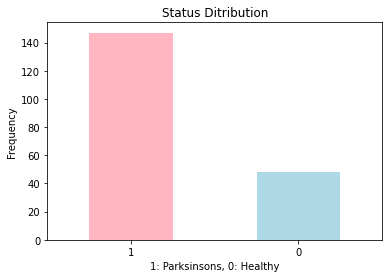

In [5]:
# Plotting target value distribution

df["status"].value_counts().plot(kind="bar",color=["lightpink","lightblue"])
plt.title("Status Ditribution")
plt.xticks(rotation=0)
plt.xlabel("1: Parksinsons, 0: Healthy")
plt.ylabel("Frequency");

In [6]:
# General information about dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MDVP:Fo(Hz)       195 non-null    float64
 1   MDVP:Fhi(Hz)      195 non-null    float64
 2   MDVP:Flo(Hz)      195 non-null    float64
 3   MDVP:Jitter(%)    195 non-null    float64
 4   MDVP:Jitter(Abs)  195 non-null    float64
 5   MDVP:RAP          195 non-null    float64
 6   MDVP:PPQ          195 non-null    float64
 7   Jitter:DDP        195 non-null    float64
 8   MDVP:Shimmer      195 non-null    float64
 9   MDVP:Shimmer(dB)  195 non-null    float64
 10  Shimmer:APQ3      195 non-null    float64
 11  Shimmer:APQ5      195 non-null    float64
 12  MDVP:APQ          195 non-null    float64
 13  Shimmer:DDA       195 non-null    float64
 14  NHR               195 non-null    float64
 15  HNR               195 non-null    float64
 16  status            195 non-null    int64  
 1

In [7]:
# Checking for missing values

df.isna().sum()

MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

In [8]:
# Numerical description about each feature

df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


### Pattern Analysis

**Presence of Parkinsons based on Average vocal fundamental frequency vs Maximum vocal fundamental frequency**

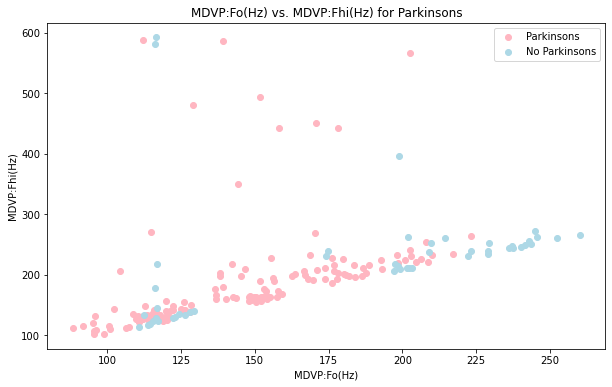

In [9]:
fig, ax=plt.subplots(figsize=[10,6])
parkinsons=ax.scatter(df["MDVP:Fo(Hz)"][df.status==1],df["MDVP:Fhi(Hz)"][df.status==1],c=["lightpink"])
no_parkinsons=ax.scatter(df["MDVP:Fo(Hz)"][df.status==0],df["MDVP:Fhi(Hz)"][df.status==0],c=["lightblue"])
ax.set(title="MDVP:Fo(Hz) vs. MDVP:Fhi(Hz) for Parkinsons",
      xlabel="MDVP:Fo(Hz)",
      ylabel="MDVP:Fhi(Hz)")
ax.legend((parkinsons,no_parkinsons),("Parkinsons","No Parkinsons"));

**Presence of Parkinsons based on Maximum vocal fundamental frequency vs Minimum vocal fundamental frequency**

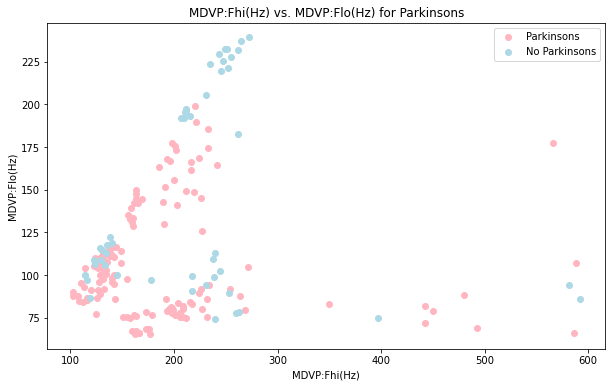

In [10]:
fig, ax=plt.subplots(figsize=[10,6])
parkinsons=ax.scatter(df["MDVP:Fhi(Hz)"][df.status==1],df["MDVP:Flo(Hz)"][df.status==1],c=["lightpink"])
no_parkinsons=ax.scatter(df["MDVP:Fhi(Hz)"][df.status==0],df["MDVP:Flo(Hz)"][df.status==0],c=["lightblue"])
ax.set(title="MDVP:Fhi(Hz) vs. MDVP:Flo(Hz) for Parkinsons",
      xlabel="MDVP:Fhi(Hz)",
      ylabel="MDVP:Flo(Hz)")
ax.legend((parkinsons,no_parkinsons),("Parkinsons","No Parkinsons"));

**Presence of Parkinsons based on Miniimum vocal fundamental frequency vs Average vocal fundamental frequency**

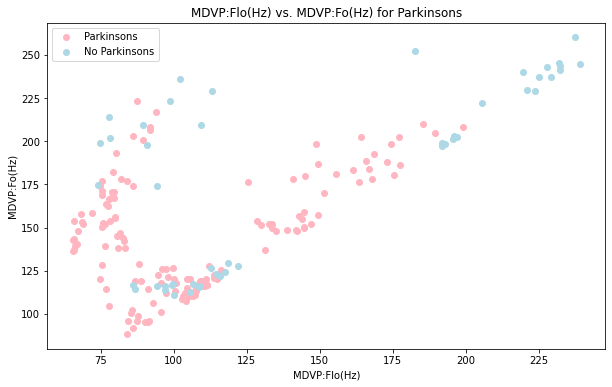

In [11]:
fig, ax=plt.subplots(figsize=[10,6])
parkinsons=ax.scatter(df["MDVP:Flo(Hz)"][df.status==1],df["MDVP:Fo(Hz)"][df.status==1],c=["lightpink"])
no_parkinsons=ax.scatter(df["MDVP:Flo(Hz)"][df.status==0],df["MDVP:Fo(Hz)"][df.status==0],c=["lightblue"])
ax.set(title="MDVP:Flo(Hz) vs. MDVP:Fo(Hz) for Parkinsons",
      xlabel="MDVP:Flo(Hz)",
      ylabel="MDVP:Fo(Hz)")
ax.legend((parkinsons,no_parkinsons),("Parkinsons","No Parkinsons"));

**Presence of Parkinsons based on measures of ratio of noise to tonal components**

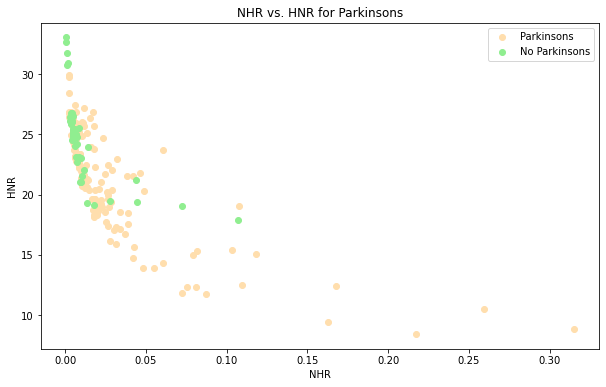

In [12]:
fig, ax=plt.subplots(figsize=[10,6])
parkinsons=ax.scatter(df["NHR"][df.status==1],df["HNR"][df.status==1],c=["navajowhite"])
no_parkinsons=ax.scatter(df["NHR"][df.status==0],df["HNR"][df.status==0],c=["lightgreen"])
ax.set(title="NHR vs. HNR for Parkinsons",
      xlabel="NHR",
      ylabel="HNR")
ax.legend((parkinsons,no_parkinsons),("Parkinsons","No Parkinsons"));

**Presence of Parkinsons based on measures of nonlinear dynamical complexity measures**

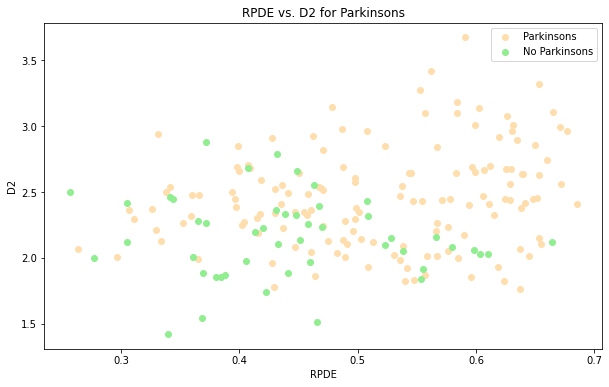

In [13]:
fig, ax=plt.subplots(figsize=[10,6])
parkinsons=ax.scatter(df["RPDE"][df.status==1],df["D2"][df.status==1],c=["navajowhite"])
no_parkinsons=ax.scatter(df["RPDE"][df.status==0],df["D2"][df.status==0],c=["lightgreen"])
ax.set(title="RPDE vs. D2 for Parkinsons",
      xlabel="RPDE",
      ylabel="D2")
ax.legend((parkinsons,no_parkinsons),("Parkinsons","No Parkinsons"));

**Data Distributions**

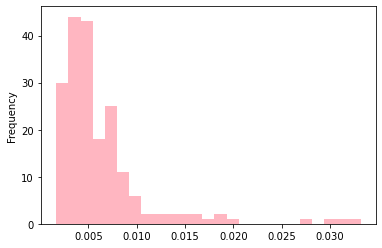

In [14]:
# Checking MDVP:Jitter(%) distribution
df["MDVP:Jitter(%)"].plot(kind="hist",color="lightpink",bins=25);

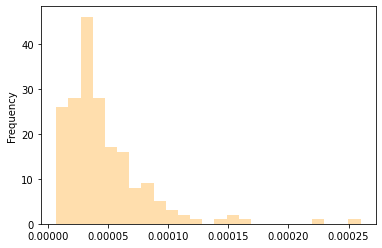

In [15]:
# Checking MDVP:Jitter(Abs) distribution
df["MDVP:Jitter(Abs)"].plot(kind="hist",color="navajowhite",bins=25);

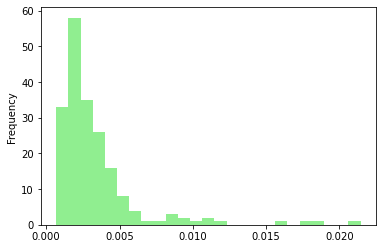

In [16]:
# Checking MDVP:RAP distribution
df["MDVP:RAP"].plot(kind="hist",color="lightgreen",bins=25);

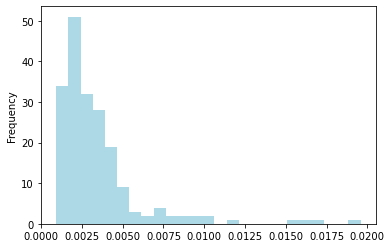

In [17]:
# Checking MDVP:PPQ distribution
df["MDVP:PPQ"].plot(kind="hist",color="lightblue",bins=25);

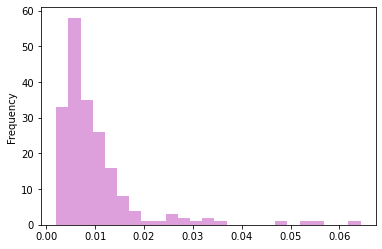

In [18]:
# Checking Jitter:DDP distribution
df["Jitter:DDP"].plot(kind="hist",color="plum",bins=25);

**Correlation Matrix**

In [19]:
df.corr()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
MDVP:Fo(Hz),1.000000,0.400985,0.596546,-0.118003,-0.382027,-0.076194,-0.112165,-0.076213,-0.098374,-0.073742,...,-0.094732,-0.021981,0.059144,-0.383535,-0.383894,-0.446013,-0.413738,-0.249450,0.177980,-0.372356
MDVP:Fhi(Hz),0.400985,1.000000,0.084951,0.102086,-0.029198,0.097177,0.091126,0.097150,0.002281,0.043465,...,-0.003733,0.163766,-0.024893,-0.166136,-0.112404,-0.343097,-0.076658,-0.002954,0.176323,-0.069543
MDVP:Flo(Hz),0.596546,0.084951,1.000000,-0.139919,-0.277815,-0.100519,-0.095828,-0.100488,-0.144543,-0.119089,...,-0.150737,-0.108670,0.210851,-0.380200,-0.400143,-0.050406,-0.394857,-0.243829,-0.100629,-0.340071
MDVP:Jitter(%),-0.118003,0.102086,-0.139919,1.000000,0.935714,0.990276,0.974256,0.990276,0.769063,0.804289,...,0.746635,0.906959,-0.728165,0.278220,0.360673,0.098572,0.693577,0.385123,0.433434,0.721543
MDVP:Jitter(Abs),-0.382027,-0.029198,-0.277815,0.935714,1.000000,0.922911,0.897778,0.922913,0.703322,0.716601,...,0.697170,0.834972,-0.656810,0.338653,0.441839,0.175036,0.735779,0.388543,0.310694,0.748162
MDVP:RAP,-0.076194,0.097177,-0.100519,0.990276,0.922911,1.000000,0.957317,1.000000,0.759581,0.790652,...,0.744919,0.919521,-0.721543,0.266668,0.342140,0.064083,0.648328,0.324407,0.426605,0.670999
MDVP:PPQ,-0.112165,0.091126,-0.095828,0.974256,0.897778,0.957317,1.000000,0.957319,0.797826,0.839239,...,0.763592,0.844604,-0.731510,0.288698,0.333274,0.196301,0.716489,0.407605,0.412524,0.769647
Jitter:DDP,-0.076213,0.097150,-0.100488,0.990276,0.922913,1.000000,0.957319,1.000000,0.759555,0.790621,...,0.744901,0.919548,-0.721494,0.266646,0.342079,0.064026,0.648328,0.324377,0.426556,0.671005
MDVP:Shimmer,-0.098374,0.002281,-0.144543,0.769063,0.703322,0.759581,0.797826,0.759555,1.000000,0.987258,...,0.987626,0.722194,-0.835271,0.367430,0.447424,0.159954,0.654734,0.452025,0.507088,0.693771
MDVP:Shimmer(dB),-0.073742,0.043465,-0.119089,0.804289,0.716601,0.790652,0.839239,0.790621,0.987258,1.000000,...,0.963202,0.744477,-0.827805,0.350697,0.410684,0.165157,0.652547,0.454314,0.512233,0.695058


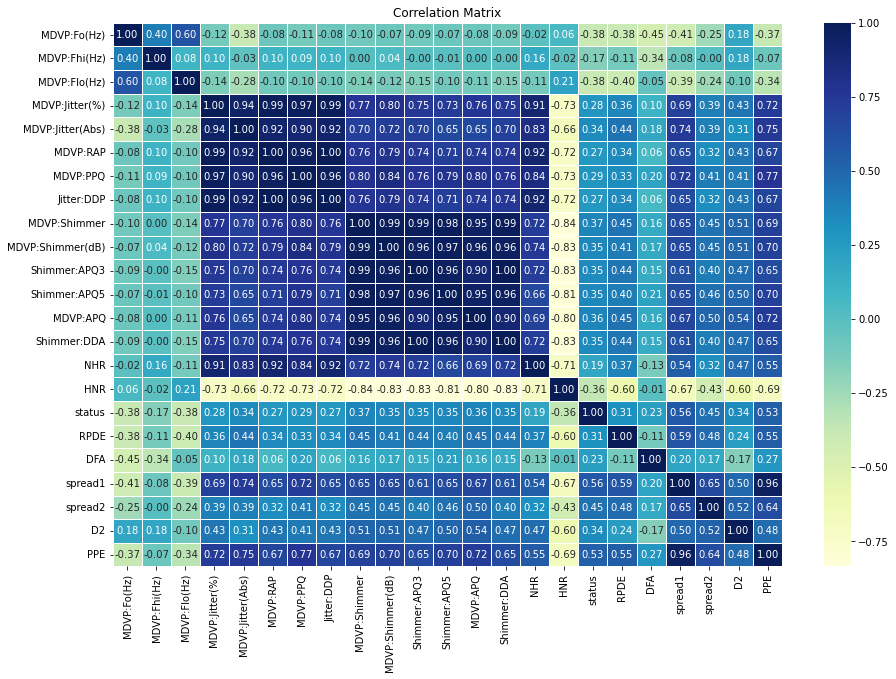

In [20]:
# Correlation matrix visualization

corr_matrix=df.corr()
fig,ax=plt.subplots(figsize=(15,10))
ax=sns.heatmap(corr_matrix,
              annot=True,
              linewidths=0.5,
              fmt=".2f",
              cmap="YlGnBu")
ax.set(title="Correlation Matrix");

## Modelling

### Features and labels data split

In [21]:
X=df.drop("status",axis=1)
y=df["status"]

In [22]:
X

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [23]:
y

0      1
1      1
2      1
3      1
4      1
      ..
190    0
191    0
192    0
193    0
194    0
Name: status, Length: 195, dtype: int64

### Train and test data split

In [24]:
# Setting up random seed
np.random.seed(42)

# Train and test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [25]:
X_train

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
5,120.552,131.162,113.787,0.00968,0.00008,0.00463,0.00750,0.01388,0.04701,0.456,...,0.03243,0.06985,0.01222,21.378,0.415564,0.825069,-4.242867,0.299111,2.187560,0.357775
135,110.453,127.611,105.554,0.00494,0.00004,0.00244,0.00315,0.00731,0.04128,0.379,...,0.03316,0.06688,0.02529,17.707,0.653427,0.706687,-5.333619,0.322044,2.631793,0.228319
122,138.190,203.522,83.340,0.00704,0.00005,0.00406,0.00398,0.01218,0.04479,0.441,...,0.03220,0.07761,0.01968,18.305,0.538016,0.741480,-5.418787,0.160267,2.090438,0.229892
167,260.105,264.919,237.303,0.00339,0.00001,0.00205,0.00186,0.00616,0.02030,0.197,...,0.01367,0.03557,0.00910,21.083,0.440988,0.628058,-7.517934,0.160414,1.881767,0.075587
85,180.978,200.125,155.495,0.00406,0.00002,0.00220,0.00244,0.00659,0.03852,0.331,...,0.02877,0.06321,0.02782,16.176,0.583574,0.727747,-5.657899,0.315903,3.098256,0.200423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,155.078,163.736,144.148,0.00168,0.00001,0.00068,0.00092,0.00204,0.01064,0.097,...,0.00928,0.01567,0.00233,29.746,0.334171,0.677930,-6.981201,0.184550,2.129924,0.106802
14,152.845,163.305,75.836,0.00294,0.00002,0.00121,0.00149,0.00364,0.01828,0.158,...,0.01246,0.03191,0.00609,24.922,0.474791,0.654027,-6.105098,0.203653,2.125618,0.170100
92,148.272,164.989,142.299,0.00459,0.00003,0.00250,0.00256,0.00750,0.04190,0.383,...,0.03051,0.07150,0.01914,18.780,0.454444,0.734504,-5.952058,0.087840,2.344336,0.186489
179,148.143,155.982,135.041,0.00392,0.00003,0.00204,0.00231,0.00612,0.01450,0.131,...,0.01263,0.02175,0.00540,23.683,0.398499,0.778349,-5.711205,0.240875,2.845109,0.192730


In [26]:
y_train

5      1
135    1
122    1
167    0
85     1
      ..
106    1
14     1
92     1
179    1
102    1
Name: status, Length: 156, dtype: int64

### Selecting a model

**Potential Models:**

1. Logistic Regression: Predicts the probability of an event based on a combo of independent variables
2. K-Neighbors Classifier: Classifies data based on the levels of similarity
3. Random Forest Classifier: Uses a set of decision trees to predict on an averaged accuracy level
4. Linear Support Vector Classifier: Predicts on the basis of classes found in linearly separable data

In [27]:
# Setting up model dictionary
models={"Logistic Regression": LogisticRegression(),
       "K-Neighbors Classifier": KNeighborsClassifier(),
       "Random Forest Classifier": RandomForestClassifier(),
       "Linear Support Vector Classifer": LinearSVC()}


def fit_score(models, X_train, X_test, y_train, y_test):
    # Docstring:
    # Fitting and scoring function
    '''
        Function purpose: To fit and evaluate a set of selected models on specified data splits
        Parameters list:
            1. models: A dictionary of models to fit and score
            2. X_train: Training data without labels - Training features
            3. X_test: Testing data without labels - Testing features
            4. y_train: Training target data with labels - Training labels
            5. y_test: Testing target data with labels - Testing labels
    '''
    # Setting up random seed:
    np.random.seed(42)
    # Dictionary store scores of each model:
    model_scores={}
    # Looping through models for fitting and scoring:
    for name,model in models.items():
        # Fitting model to training data:
        model.fit(X_train,y_train)
        # Evaulate model and store results in model_scores:
        model_scores[name]=model.score(X_test,y_test)
    return model_scores

In [28]:
model_scores=fit_score(models, X_train, X_test, y_train, y_test)

model_scores

C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


{'Logistic Regression': 0.8974358974358975,
 'K-Neighbors Classifier': 0.8205128205128205,
 'Random Forest Classifier': 0.9487179487179487,
 'Linear Support Vector Classifer': 0.8717948717948718}

**Model Comparison Visualization**

In [29]:
model_compare=pd.DataFrame(model_scores,index=["Accuracy"])
model_compare

,Logistic Regression,K-Neighbors Classifier,Random Forest Classifier,Linear Support Vector Classifer
Accuracy,0.897436,0.820513,0.948718,0.871795


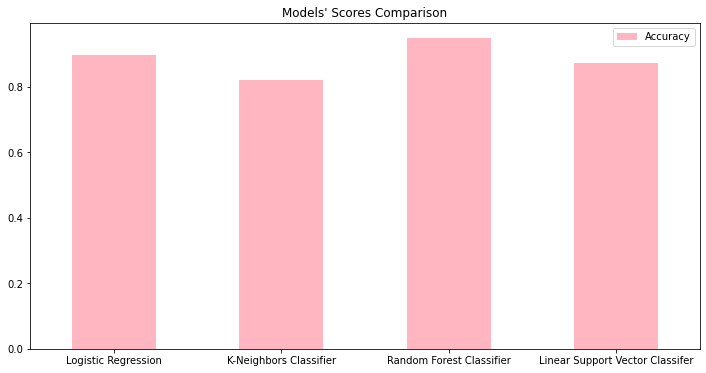

In [30]:
model_compare.T.plot(kind="bar",
                  figsize=(12,6),
                  color=["lightpink"])
plt.xticks(rotation=0)
plt.title("Models' Scores Comparison");

**Inferences after baseline modelling:**
    
+ Random Forest Classifier performs the best out of all models
+ The measurement of performance is on accuracy, for which RFC produces a score of 94.87%
+ Selected baseline model: Random Forest Classifier
+ Baseline accuracy score obtained for further improvement: 94.87%
+ Target accuracy score for successful prediction: >=90%

## Model Improvement

**Checklist to cover:**

+ Hyperparameter tuning
+ Feature importance
+ Confusion matrix
+ Extended classification evaluation metrics:
    - Precision score
    - Recall/Sensitivity score
    - F1 Score
    - Specificity score
    - Classification report
    - ROC Curve visualization
    - Area under the curve

## Hyperparamter Tuning

### Hyperparameters:

In [31]:
lg=LogisticRegression()
knn=KNeighborsClassifier()
lsvc=LinearSVC()
clf=RandomForestClassifier()

In [32]:
pd.DataFrame(lg.get_params(),index=["Hyperparameters"]).swapaxes("index","columns")

,Hyperparameters
C,1.0
class_weight,None
dual,False
fit_intercept,True
intercept_scaling,1
l1_ratio,None
max_iter,100
multi_class,auto
n_jobs,None
penalty,l2


In [33]:
pd.DataFrame(knn.get_params(),index=["Hyperparameters"]).swapaxes("index","columns")

,Hyperparameters
algorithm,auto
leaf_size,30
metric,minkowski
metric_params,None
n_jobs,None
n_neighbors,5
p,2
weights,uniform


In [34]:
pd.DataFrame(lsvc.get_params(),index=["Hyperparameters"]).swapaxes("index","columns")

,Hyperparameters
C,1.0
class_weight,None
dual,True
fit_intercept,True
intercept_scaling,1
loss,squared_hinge
max_iter,1000
multi_class,ovr
penalty,l2
random_state,None


In [35]:
pd.DataFrame(clf.get_params(),index=["Hyperparameters"]).swapaxes("index","columns")

,Hyperparameters
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


### Hyperparameter tuning with RandomizedSearchCV

**Hyperparameter Grids**

In [36]:
# Hyperparameter grid for Logistic Regression
lg_grid={"C":np.logspace(-4,4,20),
        "solver":["liblinear"]}

# Hyperparameter grid for Random Forest Classifier
clf_grid={"n_estimators":np.arange(10,1000,50),
         "max_depth":[None,3,5,10],
         "min_samples_split":np.arange(2,20,2),
         "min_samples_leaf":np.arange(1,20,2)}

# Hyperparameter grid for Linear SVC
lsvc_grid={"C":np.logspace(-4,4,20)}

# Hyperparameter grid for K Neighbors Classifier
knn_grid={"n_neighbors":np.arange(1,21)}

**Tuning models with RandomizedSearchCV**

In [37]:
# Setup random seed
np.random.seed(42)

# Setup RSCV scores dictionary
rscv_model_scores={}

*Logistic Regression*

In [38]:
# Setting up RSCV for Logistic Regression
rs_lg=RandomizedSearchCV(LogisticRegression(),
                        param_distributions=lg_grid,
                        cv=5,
                        n_iter=20,
                        verbose=True)

# Fitting this model to the training data
rs_lg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [39]:
rs_lg.best_params_

{'solver': 'liblinear', 'C': 0.615848211066026}

In [40]:
rscv_model_scores["Logistic Regression"]=rs_lg.score(X_test,y_test)
rs_lg.score(X_test,y_test)

0.8717948717948718

*Random Forest Classifier*

In [41]:
# Setting up RSCV for Random Forest Classifier
rs_clf=RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=clf_grid,
                        cv=5,
                        n_iter=20,
                        verbose=True)

# Fitting this model to the training data
rs_clf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [42]:
rs_clf.best_params_

{'n_estimators': 910,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 5}

In [43]:
rscv_model_scores["Random Forest Classifier"]=rs_clf.score(X_test,y_test)
rs_clf.score(X_test,y_test)

0.9487179487179487

*K-Neighbors Classifier*

In [44]:
# Setting up RSCV for K-Neighbors Classifier
rs_knn=RandomizedSearchCV(KNeighborsClassifier(),
                        param_distributions=knn_grid,
                        cv=5,
                        n_iter=20,
                        verbose=True)

# Fitting this model to the training data
rs_knn.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])},
                   verbose=True)

In [45]:
rs_knn.best_params_

{'n_neighbors': 1}

In [46]:
rscv_model_scores["K-Neighbors Classifier"]=rs_knn.score(X_test,y_test)
rs_knn.score(X_test,y_test)

0.7948717948717948

*Linear Support Vector Classification*

In [47]:
# Setting up RSCV for Random Forest Classifier
rs_lsvc=RandomizedSearchCV(LinearSVC(),
                        param_distributions=lsvc_grid,
                        cv=5,
                        n_iter=20,
                        verbose=True)

# Fitting this model to the training data
rs_lsvc.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearSVC(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04])},
                   verbose=True)

In [48]:
rs_lsvc.best_params_

{'C': 0.08858667904100823}

In [49]:
rscv_model_scores["Linear Support Vector Classifier"]=rs_lsvc.score(X_test,y_test)
rs_lsvc.score(X_test,y_test)

0.8205128205128205

**Model Comparison Visualization**

In [50]:
rscv_model_compare=pd.DataFrame(rscv_model_scores,index=["Accuracy"])
rscv_model_compare

,Logistic Regression,Random Forest Classifier,K-Neighbors Classifier,Linear Support Vector Classifier
Accuracy,0.871795,0.948718,0.794872,0.820513


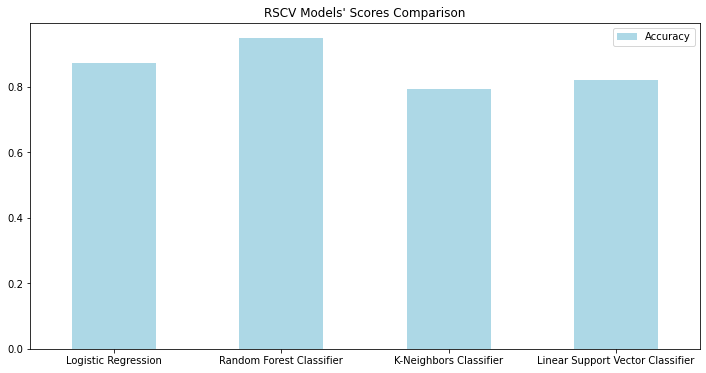

In [51]:
rscv_model_compare.T.plot(kind="bar",
                  figsize=(12,6),
                  color=["lightblue"])
plt.xticks(rotation=0)
plt.title("RSCV Models' Scores Comparison");

**Tuning models with GridSearchCV**

From the above hyperparameter tuning the Random Forest Classifier model had the best scores so we will use GridSearchCV to try to tune it further.

In [55]:
# Setup random seed
np.random.seed(42)

# Setup more specific hyperparameter grid
gs_clf_grid={"n_estimators":np.arange(905,915,1),
         "max_depth":[2],
         "min_samples_split":[3],
         "min_samples_leaf":[5]}

# Setting up GSCV for Logistic Regression
gs_clf=GridSearchCV(RandomForestClassifier(),
                        param_grid=gs_clf_grid,
                        cv=5,
                        verbose=True)

# Fitting this model to the training data
gs_clf.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2], 'min_samples_leaf': [5],
                         'min_samples_split': [3],
                         'n_estimators': array([905, 906, 907, 908, 909, 910, 911, 912, 913, 914])},
             verbose=True)

In [56]:
# Best hyperparameters after GSCV
gs_clf.best_params_

{'max_depth': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 905}

In [57]:
# Scoring the model with these best hyperparameters
gs_clf.score(X_test,y_test)

0.8974358974358975

## Tuned classifier evaluation beyond accuracy

**Factors/Metrics of evaluation:**
    
+ ROC curve and AUC score
+ Classification report
+ Recall/sensitivity score
+ Specificity score
+ F1 score
+ Confusion matrix

**Notes:**

+ Cross validation is to be utilized for better evaluation of each of these metrics
+ The evaluation will be done on the basis of predictions

In [58]:
# Predictions with best model on test data
y_preds=rs_clf.predict(X_test)
y_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1], dtype=int64)

### ROC Curve and AUC Score

C:\Users\Admin\Desktop\ML-Bootcamp\parkinsons-detection\env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


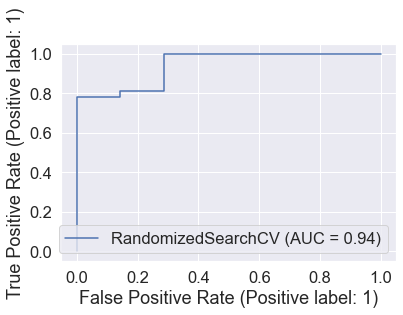

In [80]:
plot_roc_curve(rs_clf,X_test,y_test);

### Confusion Matrix

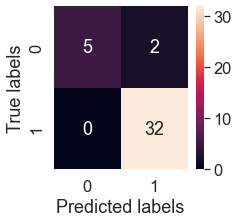

In [70]:
sns.set(font_scale=1.5)

def conf_matr(y_test,y_preds):
    '''
        Plots a confusion matrix as a heatmap
    '''
    fig,ax=plt.subplots(figsize=(3,3))
    ax=sns.heatmap(confusion_matrix(y_test,y_preds),
                  annot=True)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels");
    
conf_matr(y_test,y_preds)

### Classification Report for Single Split Data

In [61]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



### Evaluation Metrics Calculation with Cross Validation

In [75]:
# Instantiating a sample classifier based on the best model obtained
clf=RandomForestClassifier(n_estimators=910,
                         min_samples_split=2,
                         min_samples_leaf=3,
                         max_depth=5)
clf.fit(X_train,y_train);

In [76]:
# Cross-validated accuracy
cv_acc=cross_val_score(clf,
                      X,
                      y,
                      cv=5,
                      scoring="accuracy")
cv_acc_score=np.mean(cv_acc)
cv_acc_score

0.7948717948717949

In [77]:
# Cross-validated precision
cv_prec=cross_val_score(clf,
                       X,
                       y,
                       cv=5,
                       scoring="precision")
cv_prec_score=np.mean(cv_prec)
cv_prec_score

0.8256241536241535

In [78]:
# Cross-validated recall
cv_rec=cross_val_score(clf,
                      X,
                      y,
                      cv=5,
                      scoring="recall")
cv_rec_score=np.mean(cv_rec)
cv_rec_score

0.9388505747126438

In [79]:
# Cross-validated f1-score
cv_f1=cross_val_score(clf,
                      X,
                      y,
                      cv=5,
                      scoring="f1")
cv_f1_score=np.mean(cv_f1)
cv_f1_score

0.8785003232062056

In [67]:
# Visualizing cross-validated metrics
cv_metrics=pd.DataFrame({"Accuracy":cv_acc_score,
                        "Precision":cv_prec_score,
                        "Recall":cv_rec_score,
                        "F1 Score":cv_f1_score},
                       index=["Scores"])
cv_metrics

,Accuracy,Precision,Recall,F1 Score
Scores,0.789744,0.825624,0.931954,0.8785


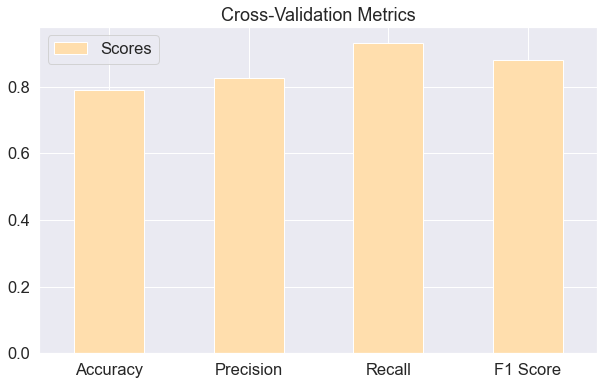

In [68]:
cv_metrics.T.plot(kind="bar",
               figsize=(10,6),
               color=["navajowhite"])
plt.title("Cross-Validation Metrics")
plt.xticks(rotation=0);

## Model Driven Exploratory Data Analysis

### Feature Importance
Here we will determine which features impact the results produced by the model the most.

In [81]:
# Instantiating a sample classifier based on the best model obtained
clf=RandomForestClassifier(n_estimators=910,
                         min_samples_split=2,
                         min_samples_leaf=3,
                         max_depth=5)
clf.fit(X_train,y_train);

In [83]:
# Check feature_importances_
feats_imp=clf.feature_importances_
feats_imp

array([0.12520239, 0.06257137, 0.0572937 , 0.02246824, 0.04288392,
       0.0411702 , 0.0286266 , 0.04336865, 0.02472591, 0.01796808,
       0.02018968, 0.03003249, 0.04229886, 0.01959982, 0.03105607,
       0.02188273, 0.02043282, 0.02266123, 0.11112639, 0.05371875,
       0.03498059, 0.12574151])

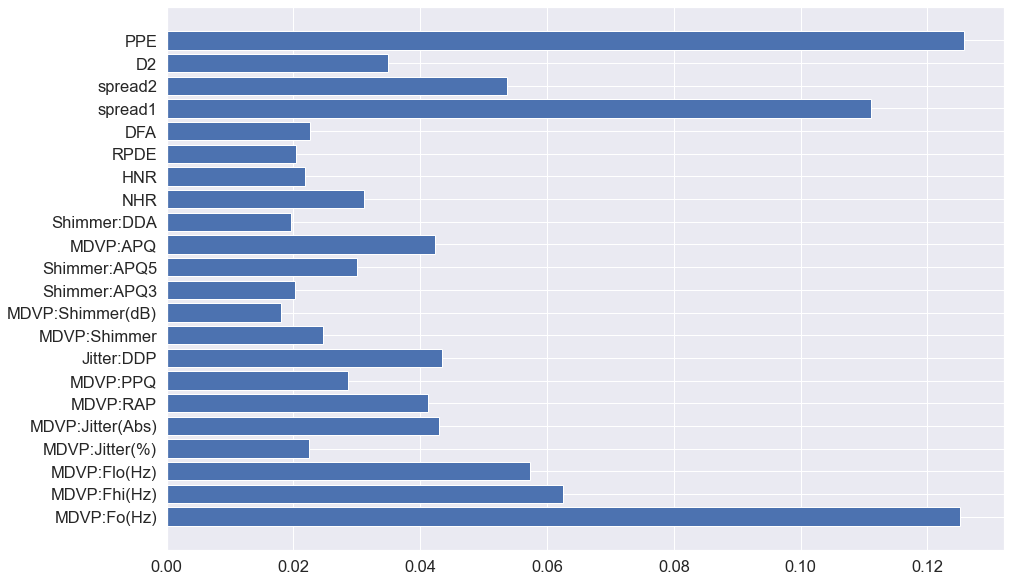

In [98]:
# Visualizing feature_importances_
plt.figure(figsize=(15,10))
plt.barh(clf.feature_names_in_,feats_imp);